<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Testing the Model](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtest Our Strategy](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-2vhau3yr
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-2vhau3yr
     |████████████████████████████████| 6.6MB 5.2MB/s 
     |████████████████████████████████| 1.6MB 38.5MB/s 
     |████████████████████████████████| 245kB 37.3MB/s 
     |████████████████████████████████| 110.5MB 36kB/s 
     |████████████████████████████████| 307kB 46.7MB/s 
     |████████████████████████████████| 12.4MB 41.5MB/s 
     |████████████████████████████████| 256kB 46.5MB/s 
     |████████████████████████████████| 583kB 41.9MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-u3x8lltu/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-u3x8lltu/pyfolio
     |████████████████████████████████| 5.5MB 42.1MB/s 
     |████████████████████████████████| 1.0MB 39.9MB/s 
     |████████████████████████████████| 


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas','numpy', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow','pyfolio'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
    !pip install git+https://github.com/quantopian/pyfolio


<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [5]:
# from config.py end_date is a string
config.END_DATE

'2020-09-30'

In [6]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
df.shape

(88680, 7)

In [8]:
df.head()

,date,open,high,low,close,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,7.460152e+08,AAPL
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1.181608e+09,AAPL
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1.289310e+09,AAPL
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,7.530488e+08,AAPL
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,6.735008e+08,AAPL


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
df = FeatureEngineer(df,
                    use_technical_indicator=True,
                    use_turbulence=True).preprocess_data()

Successfully added technical indicators
Successfully added turbulence index


In [10]:
df.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200.0,AAPL,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO,0.0,100.0,66.666667,100.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31
## Trade data split: 2019-01-01 to 2020-09-30

In [11]:
train = data_split(df, config.START_DATE,config.START_TRADE_DATE)
trade = data_split(df,config.START_TRADE_DATE,config.END_DATE)


In [12]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200.0,AAPL,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO,0.0,100.0,66.666667,100.0,0.0


In [13]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,38.722500,39.712502,38.557499,38.249401,148158800.0,AAPL,-2.003499,37.867367,-91.588048,42.250808,119.879107
0,2019-01-02,93.910004,96.269997,93.769997,92.643311,4175400.0,AXP,-3.426008,41.204982,-97.742269,26.709417,119.879107
0,2019-01-02,316.190002,323.950012,313.709991,314.645142,3292200.0,BA,-5.550592,47.010000,-21.712382,13.611972,119.879107
0,2019-01-02,124.029999,127.879997,123.000000,119.302582,4783200.0,CAT,-0.686759,48.229089,-5.091209,0.873482,119.879107
0,2019-01-02,42.279999,43.200001,42.209999,40.382099,23833500.0,CSCO,-0.960061,44.872557,-87.496850,29.529377,119.879107


In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension

In [15]:
env_setup = EnvSetup(stock_dim = stock_dimension,
                        state_space = state_space,
                        hmax = 100,
                        initial_amount = 1000000,
                        transaction_cost_pct = 0.001)

## Environment for Training



In [16]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = StockEnvTrain)

## Environment for Trading



In [17]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade) 

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [18]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model training: A2C


In [105]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
a2c_params_tuning = {'n_steps':5, 
			  'ent_coef':0.005, 
			  'learning_rate':0.0002,
			  'verbose':0,
			  'timesteps':150000}
model_a2c = agent.train_A2C(model_name = "A2C_{}".format(now), model_params = a2c_params_tuning)

==============Model Training===========
begin_total_asset:1000000
end_total_asset:2418035.95202807
total_reward:1418035.95202807
total_cost:  261967.284093091
total_trades:  72981
Sharpe:  0.7203345703576749
begin_total_asset:1000000
end_total_asset:2693109.898347975
total_reward:1693109.8983479752
total_cost:  258518.4520956466
total_trades:  73033
Sharpe:  0.8089975444489308
begin_total_asset:1000000
end_total_asset:3802538.1978647937
total_reward:2802538.1978647937
total_cost:  238215.6522577116
total_trades:  71476
Sharpe:  1.0015766122278706
begin_total_asset:1000000
end_total_asset:3314152.286360578
total_reward:2314152.286360578
total_cost:  227444.47944668992
total_trades:  70096
Sharpe:  0.8762343127916363
begin_total_asset:1000000
end_total_asset:3593025.2266229508
total_reward:2593025.2266229508
total_cost:  212149.43541967185
total_trades:  69052
Sharpe:  0.9590953775829721
begin_total_asset:1000000
end_total_asset:3152537.991785353
total_reward:2152537.991785353
total_cost

### Model 2: DDPG

In [50]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ddpg_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':100000, 
			               'verbose':0,
			               'timesteps':50000}
model_ddpg = agent.train_DDPG(model_name = "DDPG_{}".format(now), model_params = ddpg_params_tuning)

==============Model Training===========
Instructions for updating:
Use keras.layers.Dense instead.



begin_total_asset:1000000
end_total_asset:3876639.240769919
total_reward:2876639.240769919
total_cost:  9104.342746239017
total_trades:  41738
Sharpe:  1.0054552314500205
begin_total_asset:1000000
end_total_asset:7374327.234833065
total_reward:6374327.234833065
total_cost:  7039.457090340651
total_trades:  35912
Sharpe:  1.0833990891351075
begin_total_asset:1000000
end_total_asset:5248428.140151841
total_reward:4248428.140151841
total_cost:  8429.359631345911
total_trades:  35402
Sharpe:  1.03103504525587
begin_total_asset:1000000
end_total_asset:4718093.052233357
total_reward:3718093.052233357
total_cost:  10634.70695874195
total_trades:  40388
Sharpe:  0.9591292955030087
begin_total_asset:1000000
end_total_asset:5706787.595736295
total_reward:4706787.595736295
total_cost:  5088.324251377151
total_trades:  38449
Sharpe:  1.046294941645763
begin_total_asset:1000000
end_total_asset:6114

### Model 3: PPO

In [55]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ppo_params_tuning = {'n_steps':128, 
                     'nminibatches': 4,
			               'ent_coef':0.005, 
			               'learning_rate':0.00025,
			              'verbose':0,
			              'timesteps':50000}
model_ppo = agent.train_PPO(model_name = "PPO_{}".format(now), model_params = ppo_params_tuning)

==============Model Training===========


begin_total_asset:1000000
end_total_asset:3048741.3939381745
total_reward:2048741.3939381745
total_cost:  245568.3302282693
total_trades:  72462
Sharpe:  0.9202481544831457
begin_total_asset:1000000
end_total_asset:3293240.652184626
total_reward:2293240.652184626
total_cost:  208401.75301929898
total_trades:  69573
Sharpe:  0.9548892552085766
begin_total_asset:1000000
end_total_asset:3770063.9598072213
total_reward:2770063.9598072213
total_cost:  163858.87472231584
total_trades:  66022
Sharpe:  1.0100154114628663
begin_total_asset:1000000
end_total_asset:3533338.6618839577
total_reward:2533338.6618839577
total_cost:  140710.91081377305
total_trades:  63468
Sharpe:  0.8658687183317452
begin_total_asset:1000000
end_total_asset:3624214.190819685
total_reward:2624214.190819685
total_cost:  154313.0847744043
total_trades:  65276
Sharpe:  0.8993471111207018
begin_total_asset:1000000
end_total_asset:3202571.663253775
total_reward:2202571.663253775
tot

### Model 4: TD3

In [60]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
td3_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':200000, 
                     'learning_rate': 0.0002,
			               'verbose':0,
			               'timesteps':50000}
model_td3 = agent.train_TD3(model_name = "TD3_{}".format(now), model_params = td3_params_tuning)

==============Model Training===========
begin_total_asset:1000000
end_total_asset:2662114.6849694927
total_reward:1662114.6849694927
total_cost:  5154.707305372425
total_trades:  35274
Sharpe:  0.6952087010828358
begin_total_asset:1000000
end_total_asset:2988142.5784285073
total_reward:1988142.5784285073
total_cost:  1632.59511942303
total_trades:  40163
Sharpe:  0.7289450168804903
begin_total_asset:1000000
end_total_asset:2883484.519447818
total_reward:1883484.519447818
total_cost:  1214.8873761913726
total_trades:  37755
Sharpe:  0.7095756761323406
begin_total_asset:1000000
end_total_asset:2873489.4430507906
total_reward:1873489.4430507906
total_cost:  1209.6024044447397
total_trades:  37753
Sharpe:  0.7123425504445975
begin_total_asset:1000000
end_total_asset:2915279.9369537304
total_reward:1915279.9369537304
total_cost:  1228.91289347425
total_trades:  37752
Sharpe:  0.7163200645078105
begin_total_asset:1000000
end_total_asset:2895154.510926656
total_reward:1895154.510926656
total_

### Model 5: SAC

In [19]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
sac_params_tuning={
  'batch_size': 64,
 'buffer_size': 100000,
  'ent_coef':'auto_0.1',
 'learning_rate': 0.0001,
 'learning_starts':200,
 'timesteps': 50000,
 'verbose': 0}
model_sac = agent.train_SAC(model_name = "SAC_{}".format(now), model_params = sac_params_tuning)

==============Model Training===========




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





begin_total_asset:1000000
end_total_asset:2676865.4238208844
total_reward:1676865.4238208844
total_cost:  10839.881448208147
total_trades:  42067
Sharpe:  0.789144087935207

begin_total_asset:1000000
end_total_asset:2925606.225575274
total_reward:1925606.2255752739
total_cost:  3198.503225368995
total_trades:  32120
Sharpe:  0.7896195137042794
begin_total_asset:1000000
end_total_asset:2875097.1240092716
total_reward:1875097.1240092716
total_cost:  3076.895955722281
total_trades:  33705
Sharpe:  0.7659663806968906
begin_total_asset:1000000
end_total_asset:2917299.3825749317
total_reward:1917299.3825749317
total_cost:  2659.7772635509073
total_trades:  3

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be the 99% quantile of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [20]:
insample_turbulence = train.drop_duplicates(subset=['date'])

In [21]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       75.936149
std        38.178007
min         0.000000
25%        58.034373
50%        74.015054
75%        96.948888
max       230.256689
Name: turbulence, dtype: float64

In [22]:
insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [23]:
insample_turbulence_threshold

230.2566889369161

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [33]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade,
                                         turbulence_threshold=250) 

df_account_value, df_actions = DRLAgent.DRL_prediction(model=model_sac,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

previous_total_asset:1000000
end_total_asset:1363576.0875189458
total_reward:363576.0875189458
total_cost:  8124.038806180697
total trades:  7125
Sharpe:  1.1381111316843386


In [25]:
df_account_value.shape

(440, 2)

In [26]:
df_account_value.head()

,date,account_value
0,2019-01-02,1.000000e+06
1,2019-01-03,9.968619e+05
2,2019-01-04,1.003819e+06
3,2019-01-07,1.006316e+06
4,2019-01-08,1.009489e+06


In [28]:
df_actions.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,-100.0,100.0,-100.0,-100.0,100.0,100.0
2019-01-03,100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,-100.0,100.0,-100.0,-100.0,100.0,100.0
2019-01-04,100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,-100.0,100.0,-100.0,-100.0,100.0,100.0
2019-01-07,100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,-100.0,100.0,-100.0,-100.0,100.0,100.0
2019-01-08,100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,100.0,-100.0,-100.0,100.0,-100.0,100.0,-100.0,-100.0,100.0,100.0


In [ ]:
df_actions.to_csv('results/df_actions.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [29]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  21.202983712027248
sharpe ratio:  1.1381111316843386
Annual return          0.194358
Cumulative returns     0.363576
Annual volatility      0.169026
Sharpe ratio           1.138111
Calmar ratio           1.089952
Stability              0.724857
Max drawdown          -0.178318
Omega ratio            1.247259
Sortino ratio          1.603821
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.847979
Daily value at risk   -0.020532
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to S&P 500===========
annual return:  21.202983712027248
sharpe ratio:  1.1381111316843386
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)


Start date,2019-01-03
End date,2020-09-29
Total months,20
,Backtest
Annual return,19.484%
Cumulative returns,36.358%
Annual volatility,16.903%
Sharpe ratio,1.14
Calmar ratio,1.09
Stability,0.72
Max drawdown,-17.832%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.83,2020-02-12,2020-03-12,2020-06-05,83
1,8.18,2020-06-08,2020-06-26,2020-08-12,48
2,5.88,2019-07-29,2019-08-14,2019-09-12,34
3,5.42,2019-04-24,2019-05-31,2019-06-18,40
4,4.51,2020-09-02,2020-09-08,NaT,NaN


/usr/local/lib/python3.6/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


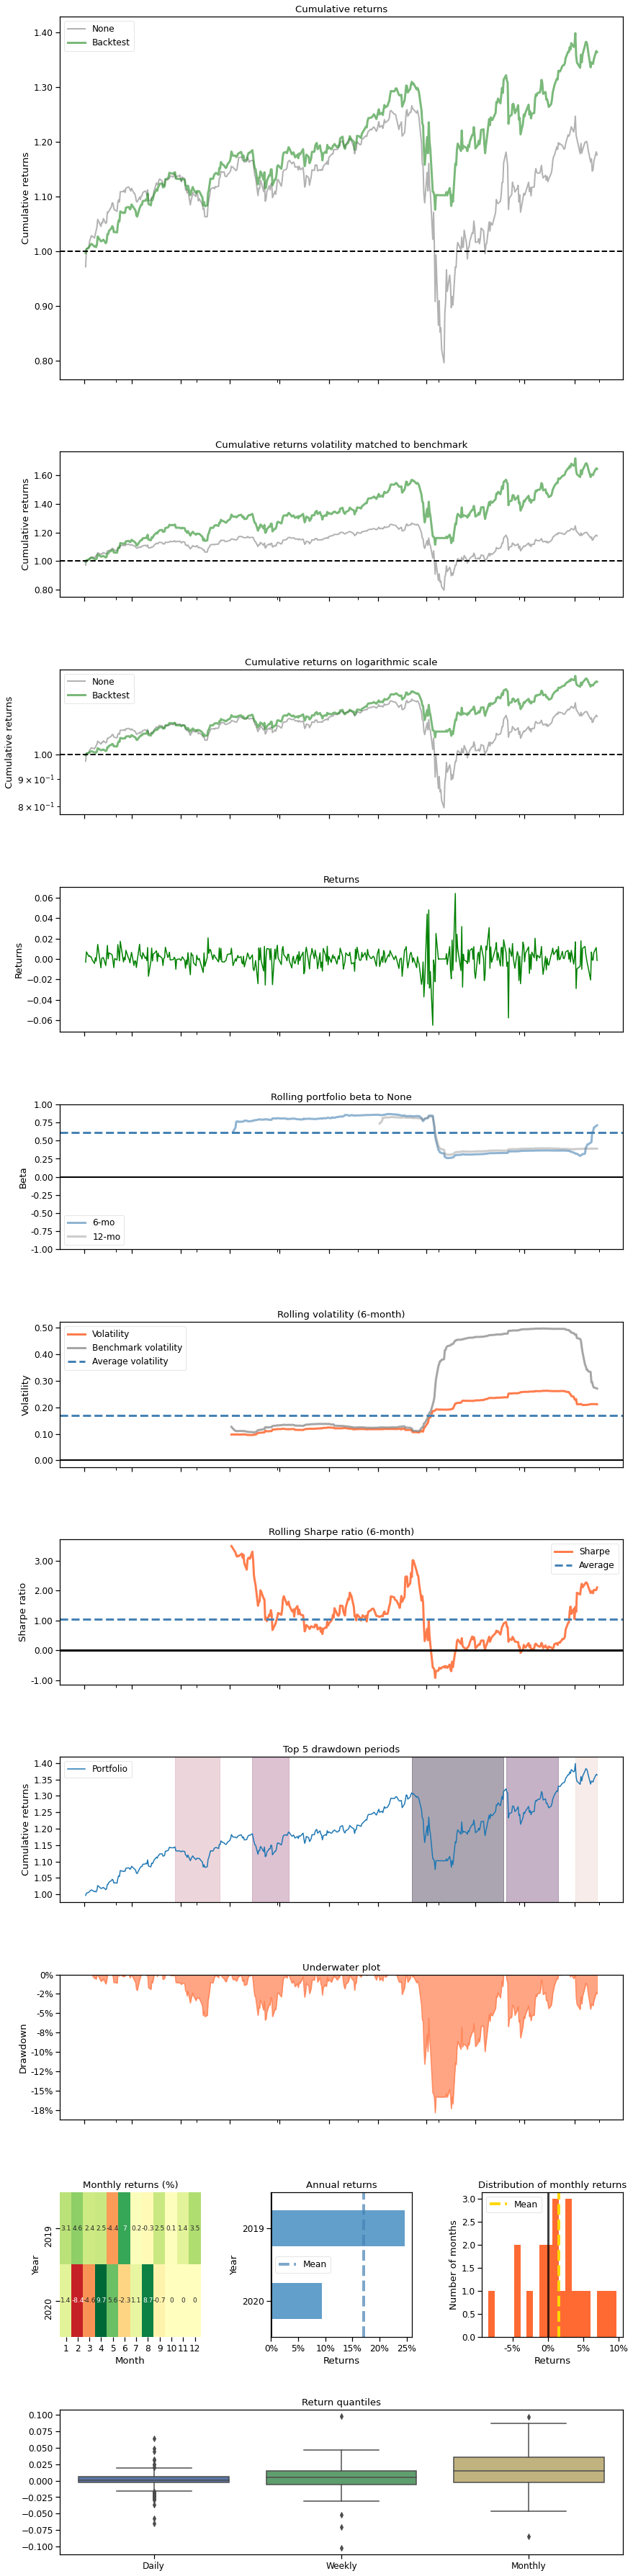

In [30]:
print("==============Compare to S&P 500===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2020-09-30')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [31]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = '2019-01-01',
                                  baseline_end = '2020-09-30')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)
Annual return          0.097239
Cumulative returns     0.175892
Annual volatility      0.287173
Sharpe ratio           0.468543
Calmar ratio           0.262198
Stability              0.010261
Max drawdown          -0.370862
Omega ratio            1.110729
Sortino ratio          0.641939
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.807113
Daily value at risk   -0.035647
Alpha                  0.000000
Beta                   1.000000
dtype: float64
